In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.read_open_dataset import DatasetOpenDataset
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from source.featlearn.simclr import SimClrFL
from sklearn import svm
from source.utils import minoritySampling
from scipy.fft import fft

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
from ts2vec import TS2Vec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
datasetName = 'PAMAP2' # PAMAP2 or HAR-UML20 or OpenDataset
FEATURE_SIZE = 32
# CLASS_LABELS = ['Sedentary', 'Light', 'Moderate', 'Vigorous']
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
RESULTS_PATH = 'results'
BALANCE = False
USE_ACC_MAGNITUDE = False

MODE = 1 # 0 -> UMAP  -  1 -> TS2Vec - 2 -> SimCLR 
NET_EPOCHS = 6


In [15]:


if datasetName == 'PAMAP2':
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3']
    # acc_signals = ['handAcc16_1', 'handAcc16_2', 'handAcc16_3']
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3',]
    signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3','heartrate']
    # signals=['heartrate']
    # heartrate
    dataset = DatasetPAMAP2(mode = 'leave-one-subject')
    
elif datasetName ==  'HAR-UML20':
    signals = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z']
    dataset = DatasetHARUML20(mode = 'leave-one-subject')

elif datasetName == 'OpenDataset':
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'heart_rate ']
    signals = ['heart_rate']
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    dataset = DatasetOpenDataset(mode = 'leave-one-subject')
    
CLASS_LABELS = dataset.intensities
if MODE == 0:
    MODEL_NAME = 'umap'
elif MODE == 1:
    MODEL_NAME = 'ts2vec'
elif MODE == 2:
    MODEL_NAME = 'simclr'


# saver = MetricsSaver(datasetName + '_PAI_{}'.format(MODEL_NAME), rows = ['test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy', 'Binary recall', 'Binary precision','Binary F1-score'])
saver = MetricsSaver(datasetName + '_PAI_{}'.format(MODEL_NAME), rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [16]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    dataset.filterSignals(signals)
    
    print(np.unique(dataset.y_train))
    print('--------------------------------')
    
    # Preparing data
    if BALANCE:
        dataset.X_train, dataset.Int_train = minoritySampling(dataset.X_train, dataset.Int_train)
    
    ts_train = TSerie(dataset.X_train, dataset.Int_train, I = dataset.I_train, dimensions=dataset.signals)
    ts_test = TSerie(dataset.X_test, dataset.Int_test, I = dataset.I_test, dimensions=dataset.signals)
    
    
    # ts_train.center(dimensions=acc_signals)
    # ts_test.center(dimensions=acc_signals)
    
    
    # minv, maxv = ts_train.minMaxNormalization()
    # minv, maxv = ts_test.minMaxNormalization(minl=minv, maxl=maxv)
    
    
    # ts_train.znorm()
    # ts_test.znorm()
    
    if USE_ACC_MAGNITUDE:
        ts_train.features =  np.linalg.norm(ts_train.X[:, :, :3], axis=2)
        ts_test.features = np.linalg.norm(ts_test.X[:, :, :3], axis=2)
        
    
    if MODE == 0:
        if not USE_ACC_MAGNITUDE:
            ts_train.folding_features_v2()
            ts_test.folding_features_v2()
    
        # Getting features
        model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
        ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
        ts_test.features = model.transform(ts_test.features)
    
    if MODE == 1:
        if USE_ACC_MAGNITUDE:
            model = TS2Vec(
                input_dims=1,
                device=0,
                output_dims=64,
                batch_size=4,
            )
            model.fit(ts_train.features, verbose=True,n_epochs = NET_EPOCHS)
            ts_train.features = model.encode(ts_train.features, encoding_window='full_series',batch_size=4,)
            ts_test.features = model.encode(ts_test.features, encoding_window='full_series',batch_size=4,)
        else:
            model = TS2Vec(
                input_dims=ts_train.D,
                device=0,
                output_dims=64,
                batch_size=4,
            )
            model.fit(ts_train.X, verbose=True,n_epochs = NET_EPOCHS)
            ts_train.features = model.encode(ts_train.X, encoding_window='full_series',batch_size=4,)
            ts_test.features = model.encode(ts_test.X, encoding_window='full_series',batch_size=4,)
    elif MODE == 2:
        model = SimClrFL(
            ts_train.D, 
            ts_train.T,
            encoding_size = 16, 
            feature_size=128, 
            filters = [16, 16, 16],
            kernels = [3, 3, 3],
        )
        model.fit(ts_train.X.transpose([0, 2, 1]), 
                    epochs=20, 
                    batch_size=32,X_val = ts_test.X.transpose([0, 2, 1]),
        )
        ts_test.features = model.encode(ts_test.X.transpose([0, 2, 1]))
        ts_train.features = model.encode(ts_train.X.transpose([0, 2, 1]))


        
    # Classifying
    # clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf = svm.SVC()
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    # train_y_bin = ts_train.y != 1
    # train_pred_bin = train_pr != 1
    
    # test_y_bin = ts_test.y != 1
    # test_pred_bin = test_pr != 1
    
    
    # test_rec = metrics.recall_score(test_y_bin, test_pred_bin)
    # test_prec = metrics.precision_score(test_y_bin, test_pred_bin)
    # test_f1 = metrics.f1_score(test_y_bin, test_pred_bin)
    
    
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)
    
    break
    # saver.addLog('test', 'Binary recall', test_rec)
    # saver.addLog('test', 'Binary precision', test_prec)
    # saver.addLog('test', 'Binary F1-score', test_f1)
    # break

predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)


[ 1  2  3  4  5  6  7 12 13 16 17 24]
--------------------------------


KeyboardInterrupt: 

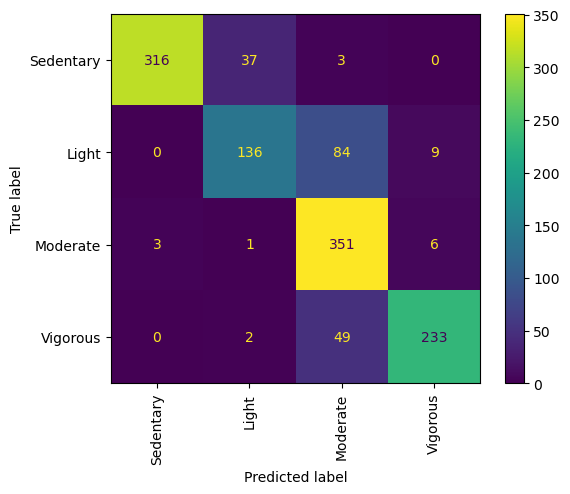

In [ ]:

saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_PAI_{}'.format(MODEL_NAME), labels=CLASS_LABELS, xrotation=90)

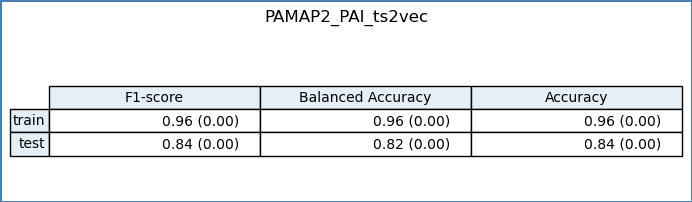

In [ ]:
saver.toImage()